<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

Let's load the MNIST dataset:

In [3]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 57657397.14it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26681870.89it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40964610.88it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18768993.86it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



... and visualize!

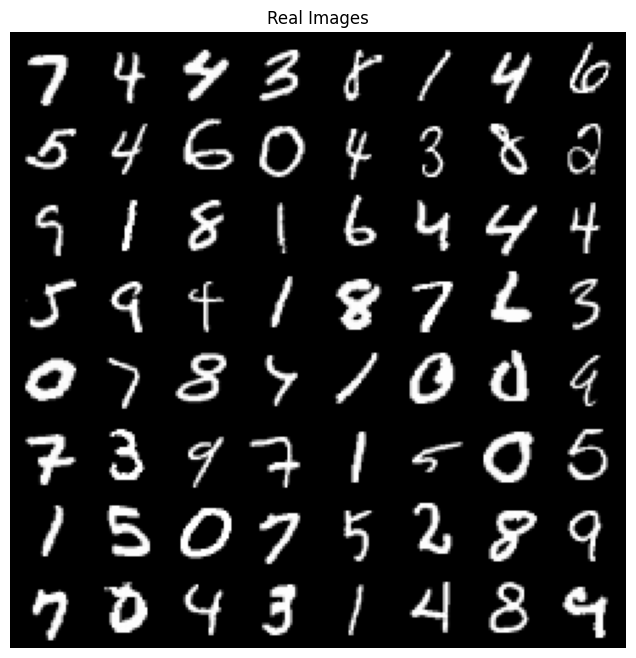

In [4]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

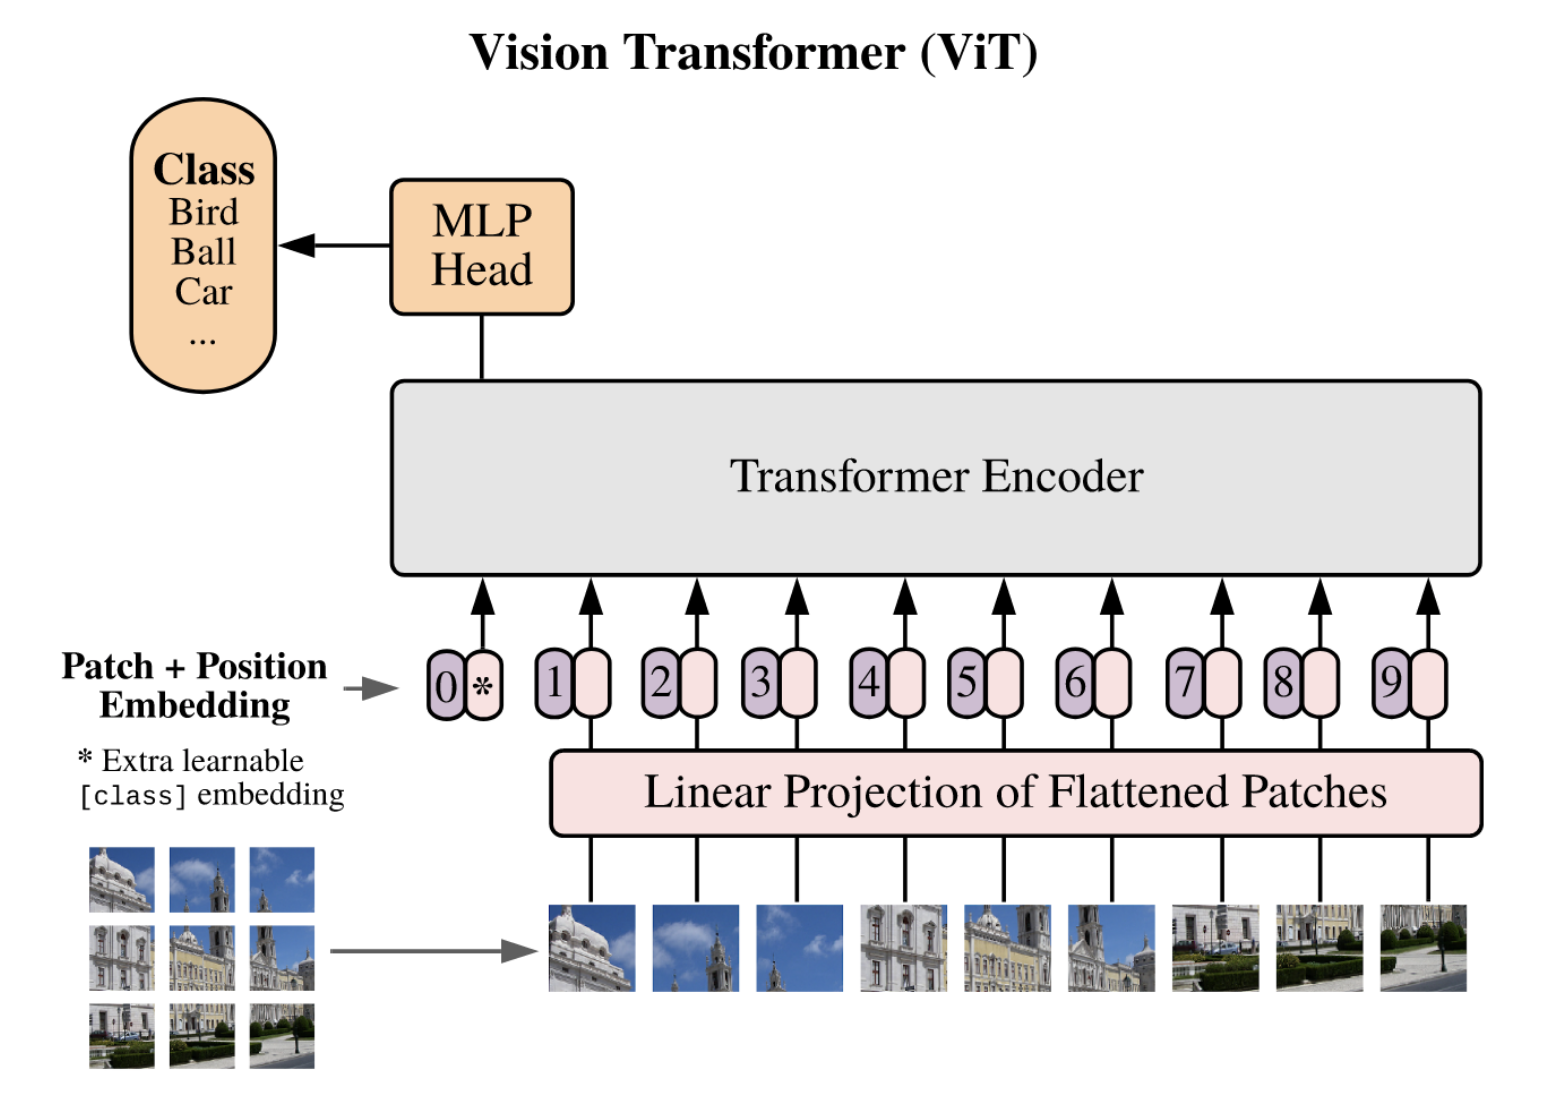

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [5]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    ## TODO
    self.projection = nn.Conv2d(in_chan,embed_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self, x):
    x = self.projection(x)

    B, C, H, W = x.shape
    ## TODO

    x = x.permute((0,2,3,1)).view((B, H*W,C))

    # x.shape -> B, N, C
    return x
patch_embed_layer = PatchEmbed()
input_tensor = torch.randn(32, 1, 28, 28)
output_tensor = patch_embed_layer(input_tensor)
print(output_tensor.shape)

torch.Size([32, 16, 128])


# Transformer encoder

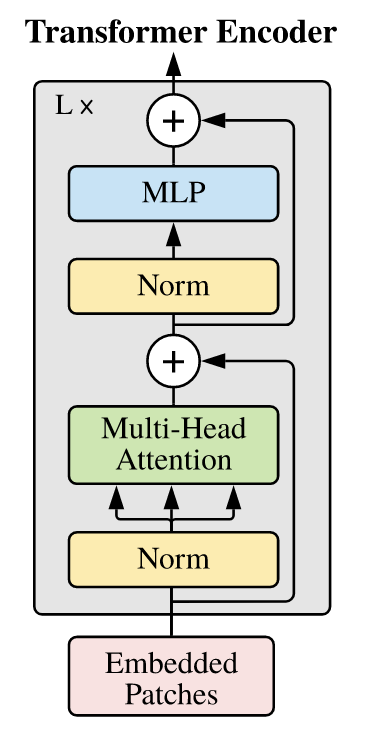

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [6]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()

    # TODO

    self.m1=nn.Linear( in_features, hid_features)
    self.m2=nn.Linear(  hid_features,in_features)


  def forward(self, x):
    # TODO
    return  self.m2( F.gelu(self.m1(x)) )


MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




In [7]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    self.q = nn.Linear(embed_dim,embed_dim)
    self.k = nn.Linear(embed_dim,embed_dim)
    self.v = nn.Linear(embed_dim,embed_dim)
    self.proj = nn.Linear(embed_dim,embed_dim)
    # TODO


  def forward(self, x):
    B, N, C = x.shape

    # TODO: compute the Q, K, V
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    # TODO: compute the attention matrix using Q and K
    attention = F.softmax(q @ k.transpose(2,1) ,dim=-1)

    # TODO: compute the final version using the attention,
    # V, and the final projection
    x = attention @ v

    return self.proj(x)


SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [8]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    self.head_dim = embed_dim // num_heads
    self.scale = self.head_dim ** -0.5
    self.num_heads = num_heads

    self.q = nn.Linear(embed_dim,embed_dim)
    self.k = nn.Linear(embed_dim,embed_dim)
    self.v = nn.Linear(embed_dim,embed_dim)
    self.proj = nn.Linear(embed_dim,embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO

    #D=number of feature in 1 attention head
    # dim =(B,H,N,D)
    q = q.reshape(B,N,self.num_heads,self.head_dim).permute(0,2,1,3)
    k = k.reshape(B,N,self.num_heads,self.head_dim).permute(0,2,1,3)
    v = v.reshape(B,N,self.num_heads,self.head_dim).permute(0,2,1,3)

    # (B,H,N,D) @ (B,H,D,N) = (B,H,N,N)
    attention=F.softmax(q@k.permute(0,1,3,2)/self.scale,dim=-1)

    # (B,H,N,N) @ (B,H,N,D)= (B,H,N,D) -> (B,N,H,D) ->  (B,N,C) car C=H*D
    x= (attention@v).permute(0,2,1,3).reshape(B,N,C)

    return self.proj(x)


MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])

donc en gros on a notre :

matrice q sert a posé une question de pertinance en gros entre les token

la matrice k sert en combinant avec q a repondre a la question

la softmax sert a rendre pour chaque token lui associé une proba d'attention avec tout les token

le softmax * v pour re ponderer l'attention

on fait tout ca pour revenir a la nos dimension initial avec un mlp

mais la qst c'est que on deverait pas faire pleusieur attention puis on concatane le resultat puis on utilise un mlp, car de cette façon la notion de multihead je pense pas elle est conservé (je ne sais pas si on image c'est la facon de faire mais ce que j'ai vu en nlp ce n'est pas la meme chose) si vous pouvez nous donnez un retour sur ce point la svp


# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

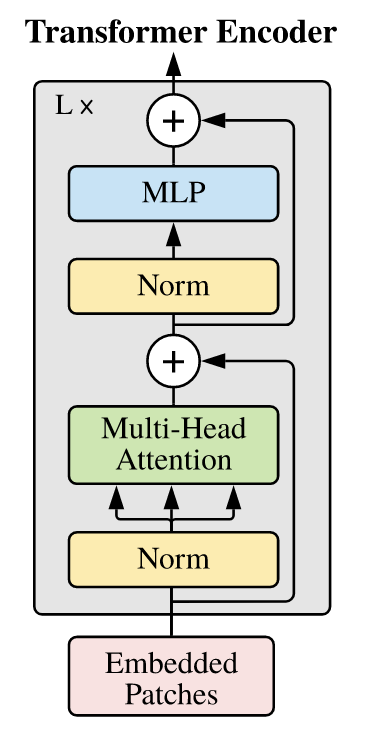

In [9]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()

    self.norm1=nn.LayerNorm(embed_dim)
    self.multi_head=MultiHeadsSelfAttention(embed_dim,num_heads)
    self.norm2=nn.LayerNorm(embed_dim)
    self.mlp=MLP(embed_dim,mlp_ratio*embed_dim)

  def forward(self, x):
    m1=self.multi_head(self.norm1(x))
    residual1=x+m1
    m2=self.mlp(self.norm2(residual1))
    residual2=m2+residual1

    return residual2

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\

This class token is initially just a vector of values that means nothing in terms of image content, but over the course of training, it is designed to learn to represent the whole image.

As in Transformers for text, each patch (including the class token) passes through a series of layers of transformation, where they are blended via the attention mechanism to form rich, contextual representations. The class token interacts with all the other patches and, through these multiple layers of attention, aggregates information about the image as a whole.

and it allows the classification layer to be more robust

- Explain what is the the positional embedding (PE) and why it is important? \\

The principle of positional embeddings is to provide information about the position of words in a text sequence, which is crucial since models such as Transformers have no intrinsic notion of word order (in other words, they are not sensitive to position by default).

without positional encoding, a Transformer model would treat "the cat is sleeping" and "the cat is sleeping" in the same way, because it would simply consider all the words without taking their order into account. Positional encoding enables the model to understand the difference in meaning brought about by the specific sequence of words.

so in our case we add PE to not forget the strcuture of the image (to conserve position of patch in the image),

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [10]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [11]:
get_positional_embeddings(((28 // 7) ** 2) + 1, 128).size()

torch.Size([1, 17, 128])

In [12]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = get_positional_embeddings(num_patches + 1, embed_dim)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x):
    x = self.patch_embed(x) ## image to patches
    B, N, C = x.shape
    ## concatenating class token
    cls_token = self.class_token.repeat(B,1,1)
    x = torch.cat([cls_token, x], dim=1)
    ## adding positional embedding
    x = x + self.pos_embed

    ## forward in the transformer
    x = self.blocks(x)

    ## Normalize the output
    x = self.norm(x)

    output = self.head(x[:, 0]) ## classification output

    return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [13]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [14]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()
model.pos_embed = model.pos_embed.cuda() #pos_embed is not a nn.Module so we need to move it to cuda manually
opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 0.5924020400687829
--- Epoch 1 ---
Train loss: 0.20050570858058644
--- Epoch 2 ---
Train loss: 0.15108203136526954
--- Epoch 3 ---
Train loss: 0.12473921567551109
--- Epoch 4 ---
Train loss: 0.11122978363893052
--- Epoch 5 ---
Train loss: 0.09594081558271257
--- Epoch 6 ---
Train loss: 0.08854186190947541
--- Epoch 7 ---
Train loss: 0.08064721506843561
--- Epoch 8 ---
Train loss: 0.07349089061472017
--- Epoch 9 ---
Train loss: 0.066315574924956
Test accuracy: 96.97


# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [16]:
from tqdm import tqdm
#For the experimentations, we will define the function below :

def train_model(embed_dim, patch_size, nb_blocks, epochs):

    model = ViT(embed_dim, nb_blocks, patch_size).cuda()
    model.pos_embed = model.pos_embed.cuda()
    opt = torch.optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        train_loss = 0.
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            opt.zero_grad()
            yhat = model(x)
            loss = F.cross_entropy(yhat, y)
            loss.backward()

            opt.step()

            train_loss += loss.item()

        # Évaluez le modèle sur l'ensemble de test à la fin de chaque époque
        test_loss = 0.
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()
                yhat = model(x)
                loss = F.cross_entropy(yhat, y)
                test_loss += loss.item()
                _, predicted = yhat.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracy = 100 * correct / total
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        train_losses.append(train_loss / len(train_loader))

    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies
    }

* Experimentations 1 : embed_dim

Training with embed_dim=16


100%|██████████| 10/10 [01:44<00:00, 10.47s/it]


Training with embed_dim=32


100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


Training with embed_dim=64


100%|██████████| 10/10 [01:39<00:00,  9.98s/it]


Training with embed_dim=128


100%|██████████| 10/10 [01:49<00:00, 10.92s/it]


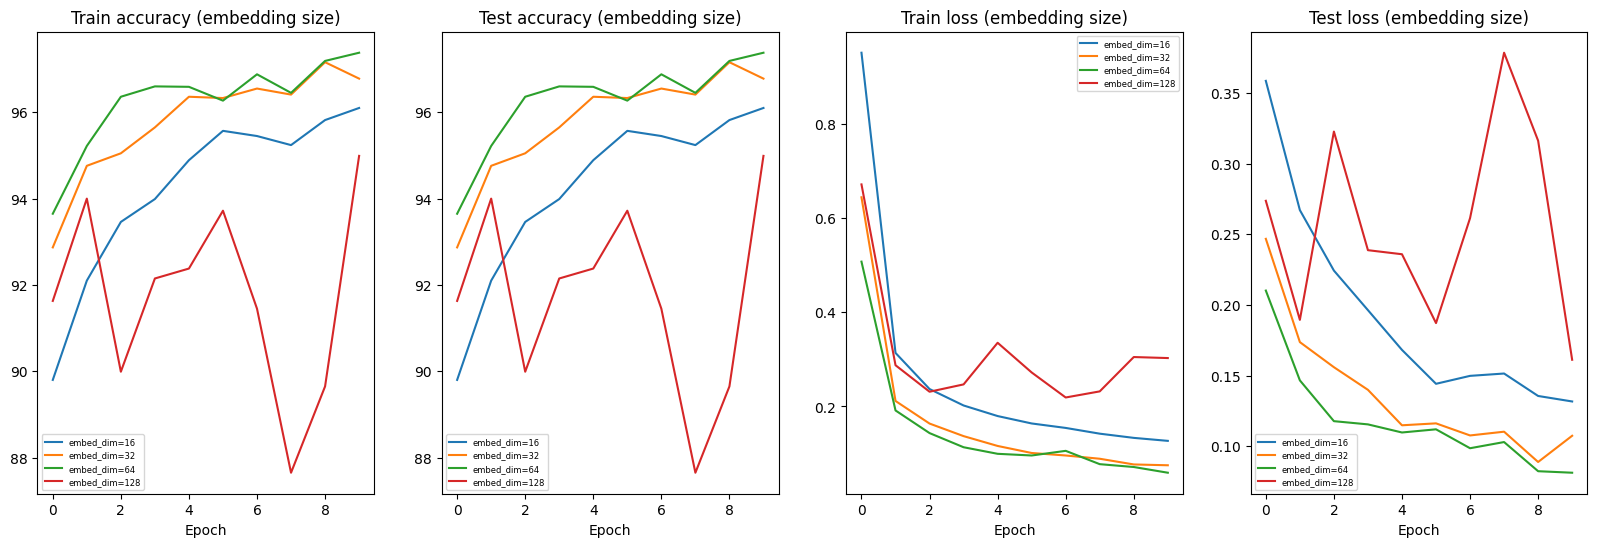

In [21]:
embed_dim_values = [16, 32, 64, 128]
patch_size = 7
nb_blocks = 2
epochs = 10

results_dict = {
    "train_losses": [],
    "test_losses": [],
    "train_accuracies": [],
    "test_accuracies": []
}


for embed_dim in embed_dim_values:
    print(f"Training with embed_dim={embed_dim}")
    results = train_model(embed_dim, patch_size, nb_blocks, epochs)


    results_dict["train_losses"].append(results["train_losses"])
    results_dict["test_losses"].append(results["test_losses"])
    results_dict["train_accuracies"].append(results["train_accuracies"])
    results_dict["test_accuracies"].append(results["test_accuracies"])

#Plots
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.title('Train accuracy (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["train_accuracies"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 2)
plt.title('Test accuracy (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["test_accuracies"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 3)
plt.title('Train loss (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["train_losses"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 4)
plt.title('Test loss (embedding size)')
plt.xlabel('Epoch')

for i, embed_dim in enumerate(embed_dim_values):
    plt.plot(results_dict["test_losses"][i], label=f"embed_dim={embed_dim}")
    plt.legend(prop={"size": 6})

plt.show()

increasing the size of the embedding gives better results because it increases the expressiveness of the model but increasing it too much, for example 128, gives poor results which may be due to a lack of data and if we use regularisation techniques we will normally get better results like the l2 norm because we will reduce the value of the parameters.

* Experimentations 2 : patch_size

Training with embed_dim=32, patch_size=2


100%|██████████| 10/10 [03:13<00:00, 19.39s/it]


Training with embed_dim=32, patch_size=4


100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


Training with embed_dim=32, patch_size=7


100%|██████████| 10/10 [01:40<00:00, 10.00s/it]


Training with embed_dim=32, patch_size=14


100%|██████████| 10/10 [01:39<00:00,  9.96s/it]


Training with embed_dim=32, patch_size=28


100%|██████████| 10/10 [01:38<00:00,  9.84s/it]


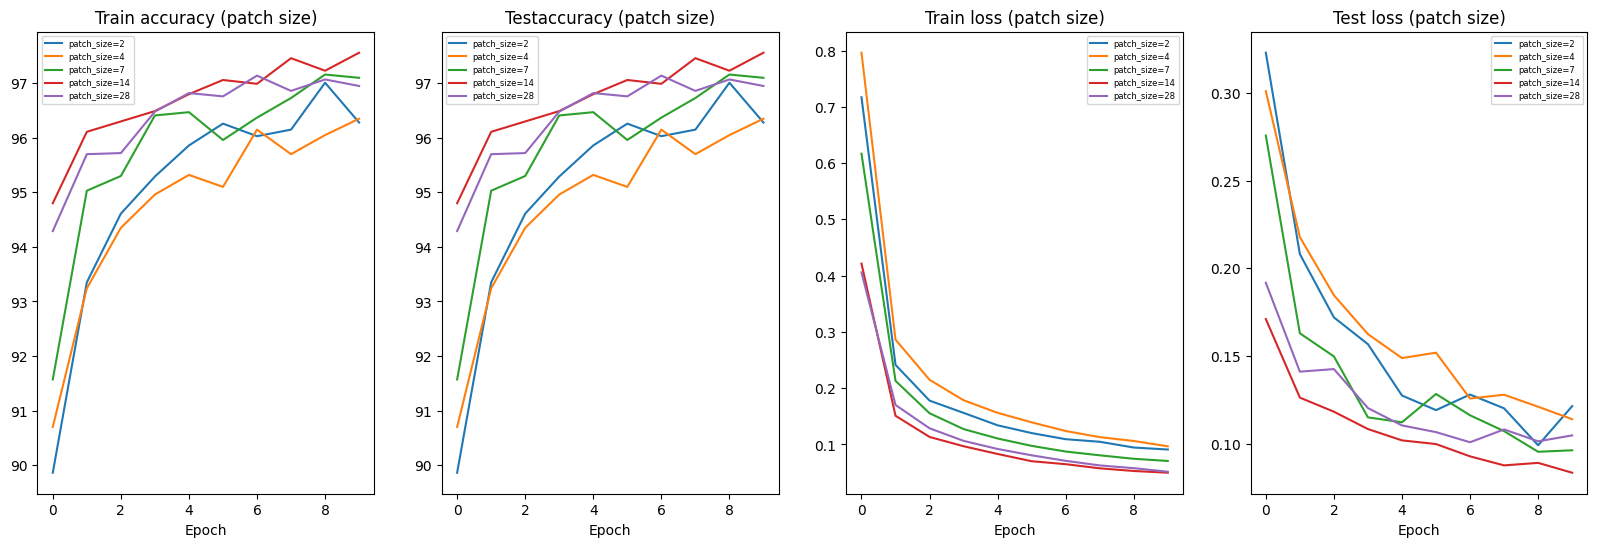

In [22]:
patch_size_values = [2,4,7, 14, 28]
embed_dim = 32
nb_blocks = 2
epochs = 10

results_dict = {
    "train_losses": [],
    "test_losses": [],
    "train_accuracies": [],
    "test_accuracies": []
}

for patch_size in patch_size_values:
    print(f"Training with embed_dim={embed_dim}, patch_size={patch_size}")
    results = train_model(embed_dim, patch_size, nb_blocks, epochs)

    results_dict["train_losses"].append(results["train_losses"])
    results_dict["test_losses"].append(results["test_losses"])
    results_dict["train_accuracies"].append(results["train_accuracies"])
    results_dict["test_accuracies"].append(results["test_accuracies"])

# Plots
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.title('Train accuracy (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["train_accuracies"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 2)
plt.title('Testaccuracy (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["test_accuracies"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 3)
plt.title('Train loss (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["train_losses"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 4)
plt.title('Test loss (patch size)')
plt.xlabel('Epoch')

for i, patch_size in enumerate(patch_size_values):
    plt.plot(results_dict["test_losses"][i], label=f"patch_size={patch_size}")
    plt.legend(prop={"size": 6})

plt.show()

by increasing the number of patches we will have more information describing the patch so when calculating the attention we will be able to write the image more because by reducing the number of tokens our attention will not have too much difficulty compared to many tokens, but for example for 28 we have less performance than 14 I think by increasing the embedding we will have better results because our features map increases and we can better represent the patch.

* Experimentations 3 : nb_blocks

Training with embed_dim=32, patch_size=28, nb_blocks = 2


100%|██████████| 10/10 [01:39<00:00,  9.90s/it]


Training with embed_dim=32, patch_size=28, nb_blocks = 4


100%|██████████| 10/10 [01:59<00:00, 11.92s/it]


Training with embed_dim=32, patch_size=28, nb_blocks = 6


100%|██████████| 10/10 [02:18<00:00, 13.85s/it]


Training with embed_dim=32, patch_size=28, nb_blocks = 8


100%|██████████| 10/10 [02:38<00:00, 15.84s/it]


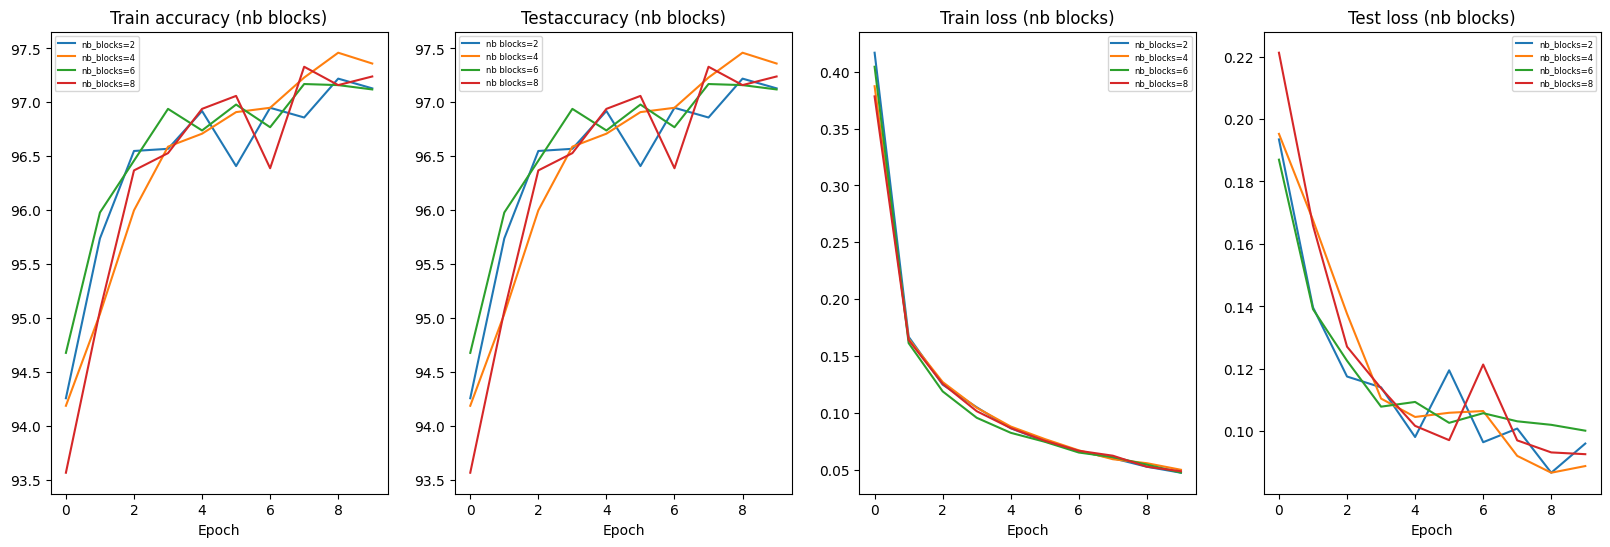

In [23]:
nb_blocks_values = [2,4,6,8]
patch_sizes = 2
embed_dim = 32
epochs = 10

results_dict = {
    "train_losses": [],
    "test_losses": [],
    "train_accuracies": [],
    "test_accuracies": []
}


for nb_blocks in nb_blocks_values:
    print(f"Training with embed_dim={embed_dim}, patch_size={patch_size}, nb_blocks = {nb_blocks}")
    results = train_model(embed_dim, patch_size, nb_blocks, epochs)


    results_dict["train_losses"].append(results["train_losses"])
    results_dict["test_losses"].append(results["test_losses"])
    results_dict["train_accuracies"].append(results["train_accuracies"])
    results_dict["test_accuracies"].append(results["test_accuracies"])

# Plots
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.title('Train accuracy (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["train_accuracies"][i], label=f"nb_blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 2)
plt.title('Testaccuracy (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["test_accuracies"][i], label=f"nb blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 3)
plt.title('Train loss (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["train_losses"][i], label=f"nb_blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.subplot(1, 4, 4)
plt.title('Test loss (nb blocks)')
plt.xlabel('Epoch')

for i, nb_blocks in enumerate(nb_blocks_values):
    plt.plot(results_dict["test_losses"][i], label=f"nb_blocks={nb_blocks}")
    plt.legend(prop={"size": 6})

plt.show()

by increasing the number of blocks, we are overlearning, so we have to increase the data or apply regularisation techniques.

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00


In [ ]:
import timm

a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=False)
x=torch.randn(32, 3, 28, 28)
model(x)

AssertionError: ignored

it doesn't match the image size because our vit is trained on 224*224 images in the cnn normally it works in the conv and for the dense layer part we have to delete it and replace it with conv too and pooling which have a window on the whole feature map. and also if we have the same resolution he will fail on the chanel

In [ ]:
x = torch.randn(32, 1, 28, 28)
x_proces =  F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
x_proces=x_proces.expand(-1, 3, -1, -1)
model(x_proces).shape

torch.Size([32, 1000])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [ ]:
# pour moi c'est la reponse la plus correcte mais car mnist n'a qu'un seul canal mais comme dans le test est a 3 je me contente de la reponse en dessous
model = timm.create_model('vit_base_patch16_224', pretrained=True,num_classes=10,img_size=28,in_chans=1)
model(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True,num_classes=10,img_size=28)
model(torch.randn(32, 3, 28, 28)).shape

torch.Size([32, 10])

c) redo the training with the pretrained ViT-S





In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=False,num_classes=10,img_size=28)

In [ ]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:

    x, y = x.cuda(), y.cuda()
    x=x.repeat(1, 3, 1, 1)

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()

    x=x.repeat(1, 3, 1, 1)

    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 1.479785647854876
--- Epoch 1 ---
Train loss: 0.6629049713169334
--- Epoch 2 ---
Train loss: 0.5679253963137995
--- Epoch 3 ---
Train loss: 0.5254855494001018
--- Epoch 4 ---
Train loss: 0.4775572459199535
--- Epoch 5 ---
Train loss: 0.45138898739682587
--- Epoch 6 ---
Train loss: 0.43878006089979144
--- Epoch 7 ---
Train loss: 0.40904578210702586
--- Epoch 8 ---
Train loss: 0.38365370120956444
--- Epoch 9 ---
Train loss: 0.3768952515587878
Test accuracy: 88.02


c) redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True,num_classes=10,img_size=28)

In [ ]:
model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x=x.repeat(1, 3, 1, 1)
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 1.6508365467921504
--- Epoch 1 ---
Train loss: 0.7853554994948129
--- Epoch 2 ---
Train loss: 0.5839418625272413
--- Epoch 3 ---
Train loss: 0.5009733305048587
--- Epoch 4 ---
Train loss: 0.4477299220526396
--- Epoch 5 ---
Train loss: 0.40556405100232756
--- Epoch 6 ---
Train loss: 0.3807895812652767
--- Epoch 7 ---
Train loss: 0.36702572854597176
--- Epoch 8 ---
Train loss: 0.35455413359695914
--- Epoch 9 ---
Train loss: 0.33492830414761865
Test accuracy: 88.14


d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.